# Check the effect of miRNA levels on PTEN protein abundance 

 "miR-25 and miR-93 (from MCM7) expression decrease PTEN protein levels, and result in activation of the Akt pathway." https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3095470/
 Could this help explain the tissue dependant effects?

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u

In [2]:
#import warnings
#warnings.filterwarnings('ignore')

In [4]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


In [5]:
'''
Params
all_prot: list of trans genes
utils: from cptac

Returns a dataframe with trans proteomics and mutation status (PTEN deletion or wt)
'''

def all_prot_format_df(cancer_object, all_prot = ['PTEN'], gene_in = 'PTEN', utils = u):
    mut_type = cancer_object.get_genotype_all_vars(gene_in)
    
    if cancer_object.get_cancer_type() not in ('luad', 'endometrial'):
        # Keep only tumor samples from proteomics
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot,
            tissue_type = 'tumor') # drop Normal samples
        
        # Reduce a multiindex 
        if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
            prot_and_mutations = utils.reduce_multiindex(prot_and_mutations, levels_to_drop = 1) 

        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        mut_type = mut_type[['Mutation']] 
        prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
        merged = prot_df.join(mut_type)
        
        # Keep only Wildtype and deletion
        compare = ['Wildtype_Tumor','Deletion']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
    
    
    # Luad has no somatic mutations for PTEN which changes some things
    elif cancer_object.get_cancer_type() in ('luad'): 
        # get_genotype_all_vars add cnv data under the column PTEN
        mut_type = mut_type.drop(columns= gene_in)
        # different code because no somatic mutation data for pten (can't join to somatic mutations)
        omics = cancer_object.join_omics_to_omics(df1_name = 'CNV', df2_name = 'proteomics', genes1 = gene_in, 
            genes2 = all_prot, tissue_type = 'tumor') # Get only tumor samples
        omics = utils.reduce_multiindex(omics, levels_to_drop = 1, flatten = True)
        omics = omics.drop(columns = 'PTEN_CNV')
        
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        merged = omics.join(mut_type) 
        
        # Keep only No_Mutation (wildtype) and deletion
        compare = ['No_Mutation','Deletion']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
        mut_wt['Mutation'] = np.where(
            mut_wt['Mutation'] == 'No_Mutation', 'Wildtype_Tumor', 'Deletion')
        
    elif cancer_object.get_cancer_type() in ('endometrial'):
        # Keep only tumor samples from proteomics
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot,
            tissue_type = 'tumor') # drop Normal samples
        
        # Reduce a multiindex 
        if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
            prot_and_mutations = utils.reduce_multiindex(prot_and_mutations, levels_to_drop = 1) 

        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        mut_type = mut_type[['Mutation']] 
        prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
        merged = prot_df.join(mut_type)
        
        # Keep two values to compare
        compare = ['Wildtype_Tumor','Nonsense_Mutation','Frame_Shift_Ins','Frame_Shift_Del']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
        mut_wt['Mutation'] = np.where(
                        mut_wt['Mutation'] == 'Wildtype_Tumor', 'Wildtype_Tumor', 'Truncation')

    return mut_wt


#  Step 1: Create Data frames with p-values and differences in median

Each cancer needs a data frame containing only samples that have PTEN cnv deletions and PTEN wildtype with trans proteomics. Use wrap_ttest to run many T-tests for all genes in the proteomics data frame. Use get_change_in_medians_df to create the data frame with change in median values. Merge both data frames. 

Load in cancer data sets from cptac. 

In [22]:
g = cptac.Gbm()
en = cptac.Endometrial()
h = cptac.Hnscc()
l = cptac.Luad()
ls = cptac.Lscc()
o = cptac.Ovarian()
col = cptac.Colon()
b = cptac.Brca()

cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (<ipython-input-22-6f95402f6a7a>, line 1)


cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-22-6f95402f6a7a>, line 3)


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-22-6f95402f6a7a>, line 5)


In [23]:
# Find miRNA
m = g.get_miRNA(tissue_type='tumor')
m = u.reduce_multiindex(m, levels_to_drop = 1)

mb_25 = m.columns.str.contains(r'miR-25')
mir25 = m[m.columns[mb_25]]
mir25

cptac warning: Due to dropping the specified levels, dataframe now has 400 duplicated column headers. (<ipython-input-23-889013e6a446>, line 3)


Name,hsa-miR-25-3p,hsa-miR-25-5p
Patient_ID,,
C3L-00104,341.652573,NaN
C3L-00365,343.139007,NaN
C3L-00674,1428.981227,NaN
C3L-00677,890.645621,6.501063
C3L-01040,164.881399,11.371131
...,...,...
C3N-03183,1587.808927,10.310448
C3N-03184,287.471381,NaN
C3N-03186,212.059094,NaN


# Run t-tests for miR-25 and miR-93

 miR-25 and miR-93 (from MCM7) expression decrease pTEN protein levels, and result in activation of the Akt pathway
 Could this help explain the tissue dependant effects?

In [24]:
def status(row, q1, q3):
    #print(row,'\tq1:',q1,'\tq3:',q3)
    status = 'na'
    for val in row: 
        if pd.isnull(val):
            continue
        val = float(val)
        if val <= q1:
            status = 'low'
        elif val >= q3:
            status = 'high'
        else:
            status = 'med'
        return status

In [25]:
luad_df = l.get_miRNA()
luad_df.columns

Index(['MIMAT0000062', 'MIMAT0000062_1', 'MIMAT0000062_2', 'MIMAT0000063',
       'MIMAT0000064', 'MIMAT0000065', 'MIMAT0000066', 'MIMAT0000067',
       'MIMAT0000067_1', 'MIMAT0000068',
       ...
       'MIMAT0049014', 'MIMAT0049015', 'MIMAT0049019', 'MIMAT0049021',
       'MIMAT0049023', 'MIMAT0049024', 'MIMAT0049026', 'MIMAT0049027',
       'MIMAT0049031', 'MIMAT0049032'],
      dtype='object', name='Name', length=2585)

In [26]:
cancer_objects = {'GBM':g, 'HNSCC':h, 'LSCC':ls, 'EC': en, 'CO':col} # miRNA not in Brca and Ov # Luad different labels

miRNA_list = ['hsa-miR-25-3p', 'hsa-miR-25-5p', 'hsa-miR-93-3p', 'hsa-miR-93-5p']

#mirna_dfs = {}
dfs = {}
quartiles = {}
all_mut_pval_df = pd.DataFrame()
all_wt_pval_df = pd.DataFrame()
all_results = pd.DataFrame()

for mirna in miRNA_list:
    mut_pval_df = pd.DataFrame()
    wt_pval_df = pd.DataFrame()
    for cancer in cancer_objects:
        df = cancer_objects[cancer].get_miRNA(tissue_type = 'tumor')
        if isinstance(df.keys(), pd.core.indexes.multi.MultiIndex):
            df = u.reduce_multiindex(df, levels_to_drop = 1)
        
        # check if miRNA is in dataframe
        if df[df.columns[df.columns.isin([mirna])]].empty == False: 
            mirna_df = df[[mirna]]
        else:
            continue

        # Find the median, quartile 1 (median of lower half) and q3 (median of upper half)
        median = float(mirna_df.median())
        lower_half = mirna_df.loc[mirna_df[mirna] <= median]
        upper_half = mirna_df.loc[mirna_df[mirna] >= median]
        q3 = float(upper_half.median())
        q1 = float(lower_half.median())
        quartiles[cancer+'_'+mirna[8:]] = (q1,q3)
        print(cancer+'_'+mirna[8:], '\nq1:', q1, '\tq3:', q3, '\n')

        # add miRNA_status column
        mirna_df['miRNA_status'] = mirna_df.apply(status, args=(q1,q3), axis = 1)
        #mirna_dfs[cancer+'_'+mirna[8:]] = mirna_df

        # Get pten proteomics for tumors with mutation
        wt_del = all_prot_format_df(cancer_objects[cancer], all_prot = ['PTEN'], gene_in = 'PTEN')
        pten = wt_del[['PTEN_proteomics','Mutation']]

        # keep miRNA_status and PTEN_proteomics
        both = pten.join(mirna_df[['miRNA_status']], how = 'outer')
        both = both.loc[both['miRNA_status'] != 'med'].dropna()
        # Combine miRNA status and PTEN mutation status
        both['miRNA_pten'] = both['miRNA_status'] + '_miRNA_PTEN_' + both['Mutation']
        both = both.replace(r'Deletion', 'del', regex=True)
        both = both.replace(r'Wildtype_Tumor', 'wt', regex=True)
        both = both.replace(r'Truncation', 'trunc', regex=True)
        
        # Put df into dfs dictionary for reference later
        dfs[cancer+'_'+mirna[8:]] = both
        
        # Keep high and low miRNA status et dfs (binary miRNA_pten) for ttest
        pten_mut = ['high_miRNA_PTEN_del', 'low_miRNA_PTEN_del', 'high_miRNA_PTEN_trunc', 'low_miRNA_PTEN_trunc']
        pten_wt = ['high_miRNA_PTEN_wt', 'low_miRNA_PTEN_wt']
        pten_mut_df = both[both['miRNA_pten'].isin(pten_mut)]
        pten_wt_df = both[both['miRNA_pten'].isin(pten_wt)]
        
        
        # Run T-tests 
        cols = ['PTEN_proteomics']
        pval_pten_mut = u.wrap_ttest(pten_mut_df, 'miRNA_pten', cols, return_all = True, correction_method = 'fdr_bh', mincount = 3)
        pval_pten_wt = u.wrap_ttest(pten_wt_df, 'miRNA_pten', cols, return_all = True, correction_method = 'fdr_bh', mincount = 3)
        pvals = [pval_pten_mut, pval_pten_wt]
        
        # Show pancancer results 
        #print(cancer, mirna, '\n', pten_mut_df.miRNA_pten.value_counts(), '\n')
        if pval_pten_mut is not None:
            pval = pval_pten_mut.rename(columns = {'P_Value': cancer+'_P_Value'})
            mut_pval_df = mut_pval_df.join(pval[[cancer+'_P_Value']], how ='right')
            #print('\tmut_enough_data', '\n')
            #print(pten_wt_df.miRNA_pten.value_counts())
        if pval_pten_wt is not None:
            pval2 = pval_pten_wt.rename(columns = {'P_Value': cancer+'_P_Value'})
            wt_pval_df = wt_pval_df.join(pval2[[cancer+'_P_Value']], how ='right')
            #print('\twt_enough_data\n\n')
        else:
            print('\tNOT enough data!', '\n\n')
            continue
        # Add mirna col
        mut_pval_df = mut_pval_df.assign(mirna = mirna)
        wt_pval_df = wt_pval_df.assign(mirna = mirna)
    
    # append dfs in one long df
    all_mut_pval_df = all_mut_pval_df.append(mut_pval_df)
    all_wt_pval_df = all_wt_pval_df.append(wt_pval_df)
    
all_mut_pval_df = all_mut_pval_df.set_index('mirna')
all_wt_pval_df = all_wt_pval_df.set_index('mirna')

cptac warning: Due to dropping the specified levels, dataframe now has 400 duplicated column headers. (<ipython-input-26-8f1fe9ef234c>, line 18)
<ipython-input-26-8f1fe9ef234c>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mirna_df['miRNA_status'] = mirna_df.apply(status, args=(q1,q3), axis = 1)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 72 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/dataset.py, line 313)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-01834 (/Users/brittanyhenderson/anaconda

GBM_25-3p 
q1: 246.47907507294065 	q3: 459.7723879490197 

Incorrectly Formatted Dataframe!
	NOT enough data! 


HNSCC_25-3p 
q1: 10.5034083691467 	q3: 11.4754598603244 



cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 109 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/dataset.py, line 313)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-02617, C3N-02727 (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/dataset.py, line 313)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 107 samples for the PTEN gene (<ipython-input-5-79911bd25e94>, line 14)
cptac warning: Due to dropping the specified levels, dataframe now has 297 duplicated column headers. (<ipython-input-26-8f1fe9ef234c>, line 18)
cptac warning: In joining the somatic_mutation table, no mutations were found for the followi

LSCC_25-3p 
q1: 8.31685 	q3: 9.261 

EC_25-3p 
q1: 10.46 	q3: 11.440000000000001 



cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 96 samples for the PTEN gene (<ipython-input-5-79911bd25e94>, line 14)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 20 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/dataset.py, line 313)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 20 samples for the PTEN gene (<ipython-input-5-79911bd25e94>, line 55)
<ipython-input-5-79911bd25e94>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

CO_25-3p 
q1: 11.4106 	q3: 12.1814 

GBM_25-5p 
q1: 4.969485242981278 	q3: 11.965394494185968 



cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 72 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/dataset.py, line 313)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-01834 (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/dataset.py, line 313)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 72 samples for the PTEN gene (<ipython-input-5-79911bd25e94>, line 14)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 109 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-p

Incorrectly Formatted Dataframe!
	NOT enough data! 


HNSCC_25-5p 
q1: 3.8698714061777095 	q3: 5.375734538583161 



cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 107 samples for the PTEN gene (<ipython-input-5-79911bd25e94>, line 14)
cptac warning: Due to dropping the specified levels, dataframe now has 297 duplicated column headers. (<ipython-input-26-8f1fe9ef234c>, line 18)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 96 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/dataset.py, line 313)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 96 samples for the PTEN gene (<ipython-input-5-79911bd25e94>, line 14)


LSCC_25-5p 
q1: 3.0574 	q3: 4.806 

EC_25-5p 
q1: 3.89 	q3: 5.27 

Incorrectly Formatted Dataframe!
	NOT enough data!

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 20 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/dataset.py, line 313)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 20 samples for the PTEN gene (<ipython-input-5-79911bd25e94>, line 55)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 100 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/dataset.py, line 313)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: 05CO045 (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-pac

 


CO_25-5p 
q1: 3.8924 	q3: 5.1389 

Incorrectly Formatted Dataframe!
GBM_93-3p 
q1: 6.026951986515526 	q3: 15.752824962835156 



cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 101 samples for the PTEN gene (<ipython-input-5-79911bd25e94>, line 14)
cptac warning: proteomics data was not found for the following samples, so proteomics data columns were filled with NaN for these samples: 01CO001, 05CO005, 05CO007, 05CO014, 05CO055, 11CO059, 11CO060, 14CO002, 16CO012, 24CO005 (<ipython-input-5-79911bd25e94>, line 14)
cptac warning: Due to dropping the specified levels, dataframe now has 400 duplicated column headers. (<ipython-input-26-8f1fe9ef234c>, line 18)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 72 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/dataset.py, line 313)
cptac warning: CNV data was not found for the following sample

Incorrectly Formatted Dataframe!
	NOT enough data! 


HNSCC_93-3p 
q1: 4.96624587322494 	q3: 5.97842446544086 

Incorrectly Formatted Dataframe!


cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 109 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/dataset.py, line 313)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-02617, C3N-02727 (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/dataset.py, line 313)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 107 samples for the PTEN gene (<ipython-input-5-79911bd25e94>, line 14)
cptac warning: Due to dropping the specified levels, dataframe now has 297 duplicated column headers. (<ipython-input-26-8f1fe9ef234c>, line 18)
cptac warning: In joining the somatic_mutation table, no mutations were found for the followi

LSCC_93-3p 
q1: 2.6989 	q3: 4.1227 

EC_93-3p 
q1: 5.325 	q3: 6.23 



cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 96 samples for the PTEN gene (<ipython-input-5-79911bd25e94>, line 14)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 20 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/dataset.py, line 313)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 20 samples for the PTEN gene (<ipython-input-5-79911bd25e94>, line 55)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 100 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3

CO_93-3p 
q1: 4.0696 	q3: 4.9313 

Incorrectly Formatted Dataframe!
GBM_93-5p 
q1: 3713.764878292884 	q3: 6616.05961417926 



cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 72 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/dataset.py, line 313)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-01834 (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/dataset.py, line 313)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 72 samples for the PTEN gene (<ipython-input-5-79911bd25e94>, line 14)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 109 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-p

Incorrectly Formatted Dataframe!
	NOT enough data! 


HNSCC_93-5p 
q1: 11.4417874257584 	q3: 12.319477377839402 



cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 107 samples for the PTEN gene (<ipython-input-5-79911bd25e94>, line 14)
cptac warning: Due to dropping the specified levels, dataframe now has 297 duplicated column headers. (<ipython-input-26-8f1fe9ef234c>, line 18)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 96 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/dataset.py, line 313)


Incorrectly Formatted Dataframe!
LSCC_93-5p 
q1: 12.1553 	q3: 13.1487 



cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 96 samples for the PTEN gene (<ipython-input-5-79911bd25e94>, line 14)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 20 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/dataset.py, line 313)


EC_93-5p 
q1: 11.77 	q3: 12.75 



cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 20 samples for the PTEN gene (<ipython-input-5-79911bd25e94>, line 55)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 100 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/dataset.py, line 313)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: 05CO045 (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/dataset.py, line 313)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 101 samples for the PTEN gene (<ipython-input-5-79911bd25e94>, line 14)
cptac warning: 

CO_93-5p 
q1: 10.8829 	q3: 11.7317 



# PTEN Deletion 

See results for pten deletions/truncations: high miRNA vs. low miRNA

In [27]:
all_mut_pval_df

,GBM_P_Value,HNSCC_P_Value,LSCC_P_Value,EC_P_Value,CO_P_Value
mirna,,,,,
hsa-miR-25-3p,0.253952,0.346111,0.274014,0.005414,0.245110
hsa-miR-25-5p,0.519733,0.529402,0.370078,0.076778,NaN
hsa-miR-93-3p,0.112817,NaN,0.274080,0.001486,NaN
hsa-miR-93-5p,0.355066,NaN,0.143176,0.000132,0.255875


In [28]:
# Keep only sig pvals
mut_results = all_mut_pval_df.replace(np.NaN, -1) # -1 = not enough data to do test
mut_sig = mut_results.where(mut_results < 0.05, 'ns') # replace when false
mut_sig = mut_sig.replace(-1, 'NaN') 
mut_sig

,GBM_P_Value,HNSCC_P_Value,LSCC_P_Value,EC_P_Value,CO_P_Value
mirna,,,,,
hsa-miR-25-3p,ns,ns,ns,0.00541367,ns
hsa-miR-25-5p,ns,ns,ns,ns,NaN
hsa-miR-93-3p,ns,NaN,ns,0.00148615,NaN
hsa-miR-93-5p,ns,NaN,ns,0.000132311,ns


# PTEN Wildtype

See results for pten wt: high miRNA vs. low miRNA

In [29]:
all_wt_pval_df

,HNSCC_P_Value,LSCC_P_Value,EC_P_Value,CO_P_Value
mirna,,,,
hsa-miR-25-3p,0.432684,0.021908,0.999274,0.895724
hsa-miR-25-5p,0.125408,0.372408,NaN,0.978535
hsa-miR-93-3p,0.146312,0.000833,0.808077,0.303167
hsa-miR-93-5p,0.118629,0.000045,0.795755,0.770092


In [30]:
# Keep only sig pvals
wt_results = all_wt_pval_df.replace(np.NaN, -1) # replace if not enough data to do test
wt_sig = wt_results.where(wt_results < 0.05, 'ns')
wt_sig = wt_sig.replace(-1, 'NaN') 
wt_sig['GBM_P_Value'] = 'NaN' # Add GBM (never enough data to do test, never added to df)
wt_sig

,HNSCC_P_Value,LSCC_P_Value,EC_P_Value,CO_P_Value,GBM_P_Value
mirna,,,,,
hsa-miR-25-3p,ns,0.0219083,ns,ns,NaN
hsa-miR-25-5p,ns,ns,NaN,ns,NaN
hsa-miR-93-3p,ns,0.000833141,ns,ns,NaN
hsa-miR-93-5p,ns,4.47259e-05,ns,ns,NaN


In [14]:
# Check same amount of samples with high and low miRNA

In [31]:
name = 'GBM_93-5p'

#q = quartiles[name]
#print('qartiles:', q)

plot_df = dfs[name]
plot_df = plot_df.dropna(how = 'any')

print('total vals:', len(plot_df))
print(plot_df['miRNA_status'].value_counts())
plot_df['miRNA_pten'].value_counts()


total vals: 49
high    25
low     24
Name: miRNA_status, dtype: int64


high_miRNA_PTEN_del    22
low_miRNA_PTEN_del     19
low_miRNA_PTEN_wt       5
high_miRNA_PTEN_wt      3
Name: miRNA_pten, dtype: int64

# Create boxplot of sig results

In [47]:
# Choose an miRNA
mirna_25_3p = 'hsa-miR-25-3p'
mirna_25_5p = 'hsa-miR-25-5p'
mirna_93_3p = 'hsa-miR-93-3p'
mirna_93_5p = 'hsa-miR-93-5p'

mirna = mirna_93_3p # replace with miRNA you want to look at
mut_mirna_pval = mut_sig.loc[[mirna] ,:]
wt_mirna_pval = wt_sig.loc[[mirna] ,:]

In [48]:
# Format df for boxplot
cancer_list = ['GBM','HNSCC','LSCC','EC','CO']
mirna_plot_df = pd.DataFrame()

for cancer in cancer_list:
    df = dfs[cancer+'_'+mirna[8:]].assign(cancer = cancer+'_'+mirna[4:])
    mirna_plot_df = mirna_plot_df.append(df)

most_cancers_df = mirna_plot_df.loc[mirna_plot_df['cancer'] != 'HNSCC_'+mirna[4:]]
hnscc_df = mirna_plot_df.loc[mirna_plot_df['cancer'] == 'HNSCC_'+mirna[4:]]

In [49]:
print('PTEN del/trunc:\n', mut_mirna_pval)
print('\nPTEN wt:\n', wt_mirna_pval)

PTEN del/trunc:
               GBM_P_Value HNSCC_P_Value LSCC_P_Value  EC_P_Value CO_P_Value
mirna                                                                      
hsa-miR-93-3p          ns           NaN           ns  0.00148615        NaN

PTEN wt:
               HNSCC_P_Value LSCC_P_Value EC_P_Value CO_P_Value GBM_P_Value
mirna                                                                     
hsa-miR-93-3p            ns  0.000833141         ns         ns         NaN


In [50]:
# Get pval annotation symbols
mut_symbols = {}
wt_symbols = {}
for c in cancer_list:
    # Get symbols for mut tests
    if isinstance(mut_mirna_pval[c+'_P_Value'][0], float):
        if mut_mirna_pval[c+'_P_Value'][0] < 0.05:
            mut_symbols[c] = "pval = {:.5f}".format(float(mut_mirna_pval[c+'_P_Value']))
    elif mut_mirna_pval[c+'_P_Value'][0] == 'NA':
        mut_symbols[c] = 'NA'
    else:
        mut_symbols[c] = 'ns'
    # Get symbols for wt tests
    if isinstance(wt_mirna_pval[c+'_P_Value'][0], float):
        if wt_mirna_pval[c+'_P_Value'][0] < 0.05:
            wt_symbols[c] = "pval = {:.5f}".format(float(wt_mirna_pval[c+'_P_Value']))
    elif wt_mirna_pval[c+'_P_Value'][0] == 'NA':
        wt_symbols[c] = 'NA'
    else:
        wt_symbols[c] = 'ns'
        
wt_symbols

{'GBM': 'ns', 'HNSCC': 'ns', 'LSCC': 'pval = 0.00083', 'EC': 'ns', 'CO': 'ns'}

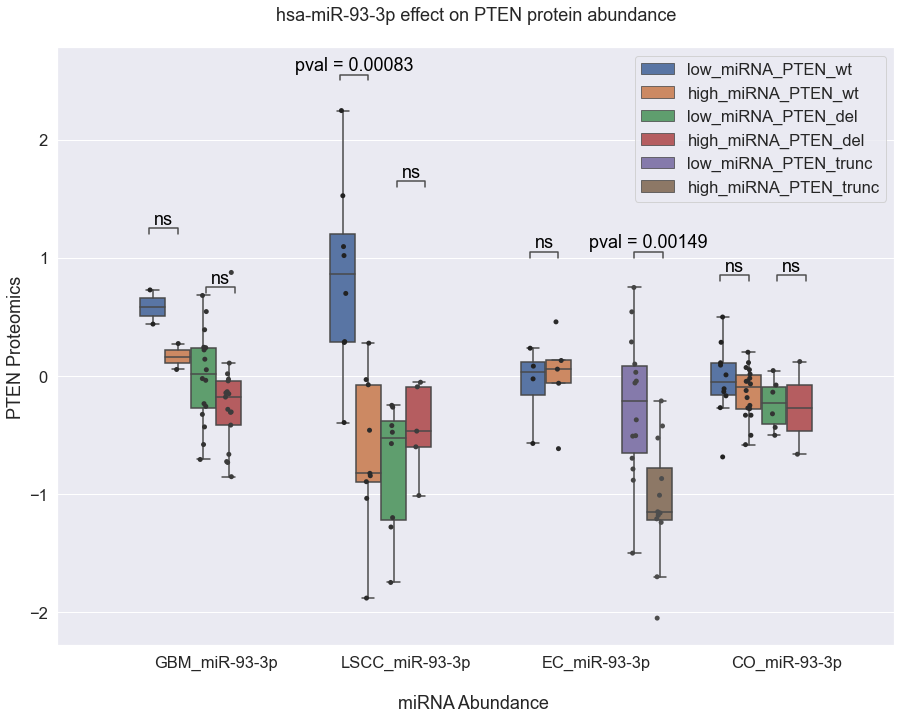

In [51]:
# Combined Plot 
gene = 'PTEN'
plt.rcParams['figure.figsize']=(15,11) #size of plot
sns.set(font_scale = 1.5)

boxplot = sns.boxplot(x='cancer', y=gene+'_proteomics', data = most_cancers_df, 
                      hue='miRNA_pten', hue_order = ["low_miRNA_PTEN_wt", "high_miRNA_PTEN_wt",
                      "low_miRNA_PTEN_del", "high_miRNA_PTEN_del", "low_miRNA_PTEN_trunc", 
                      "high_miRNA_PTEN_trunc"], showfliers = False)    
boxplot.set_title(mirna+' effect on PTEN protein abundance\n')
boxplot = sns.stripplot(x='cancer', y=gene+'_proteomics', data = most_cancers_df, jitter = True, 
                           color = ".3", hue='miRNA_pten', hue_order = ["low_miRNA_PTEN_wt", "high_miRNA_PTEN_wt",
                            "low_miRNA_PTEN_del", "high_miRNA_PTEN_del", "low_miRNA_PTEN_trunc", "high_miRNA_PTEN_trunc"], 
                            dodge = True)
boxplot.set(xlabel = "\nmiRNA Abundance ", ylabel = 'PTEN Proteomics')

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:6], labels[0:6])

format_pval_annotation(wt_symbols['GBM'], -0.35, -0.2, 1.2) 
format_pval_annotation(mut_symbols['GBM'], -0.05, 0.1, 0.7)  

format_pval_annotation(wt_symbols['LSCC'], .65, .8, 2.5)
format_pval_annotation(mut_symbols['LSCC'], .95, 1.1, 1.6) 

format_pval_annotation(wt_symbols['EC'], 1.65, 1.8, 1)
format_pval_annotation(mut_symbols['EC'], 2.2, 2.35, 1)

format_pval_annotation(wt_symbols['CO'], 2.65, 2.8, 0.8)
format_pval_annotation(mut_symbols['CO'], 2.95, 3.1, 0.8)


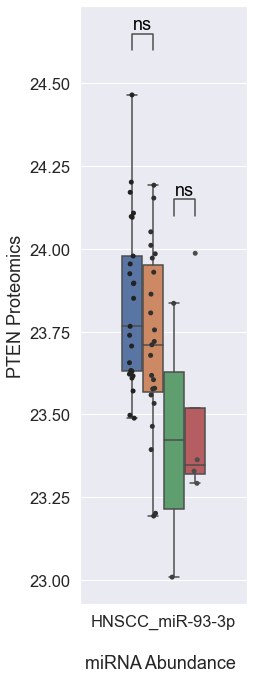

In [52]:
# Hnscc
gene = 'PTEN'

plt.rcParams['figure.figsize']=(3,11) #size of plot
sns.set(font_scale = 1.5)
boxplot = sns.boxplot(x='cancer', y=gene+'_proteomics', data = hnscc_df, 
                      hue='miRNA_pten', hue_order = ["low_miRNA_PTEN_wt", "high_miRNA_PTEN_wt",
                      "low_miRNA_PTEN_del", "high_miRNA_PTEN_del"], showfliers = False)    
#boxplot.set_title('Level of miRNA significant effects on PTEN protein abundance\n')
boxplot = sns.stripplot(x='cancer', y=gene+'_proteomics', data = hnscc_df, jitter = True, 
                           color = ".3", hue='miRNA_pten', hue_order = ["low_miRNA_PTEN_wt", 
                        "high_miRNA_PTEN_wt", "low_miRNA_PTEN_del", "high_miRNA_PTEN_del"], dodge = True)
boxplot.set(xlabel = "\nmiRNA Abundance ", ylabel = 'PTEN Proteomics')

# format legend
boxplot.get_legend().set_visible(False)
#handles, labels = boxplot.get_legend_handles_labels()
#plt.legend(handles[0:4], labels[0:4])

format_pval_annotation(wt_symbols['HNSCC'], -0.3, -.1, 24.6) 
format_pval_annotation(mut_symbols['HNSCC'], .1, .3, 24.1)
 
#boxplot.figure.savefig(".png", dpi = 300)

plt.show()
plt.clf()
plt.close()